In [ ]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("elliotp/idoc-mugshots")



100%|██████████| 6.15G/6.15G [03:57<00:00, 27.9MB/s]

Extracting files...
Extracting files...


Initializing DataLoader...
Labels loaded with 50000 records.
DataLoader initialized
Columns in labels DataFrame: Index(['ID', 'Sex', 'Height', 'Weight', 'Hair', 'Eyes', 'Race', 'Sex Offender',
       'Offense'],
      dtype='object')
head:        ID   Sex        Height    Weight                    Hair   Eyes   Race  \
0  A00147  Male  5 ft. 07 in.  185 lbs.                   Brown   Blue  White   
1  A00198  Male  6 ft. 02 in.  190 lbs.           Red or Auburn  Brown  White   
2  A00360  Male  5 ft. 09 in.  167 lbs.  Gray or Partially Gray  Green  White   
3  A00367  Male  6 ft. 00 in.  245 lbs.                   Black  Brown  Black   
4  A01054  Male  5 ft. 07 in.  166 lbs.         Salt and Pepper  Brown  Black   

   Sex Offender                                            Offense  
0          True  AGGR KIDNAPPING-NO RANSOM, ATTEMPT MURDER/INTE...  
1         False  CRIM DMG TO PROP $300-10K, ATTEMPT AGG BATTERY...  
2         False  ARMED ROBBERY, OBSTRUCTING JUSTICE, CARRY/POSS...

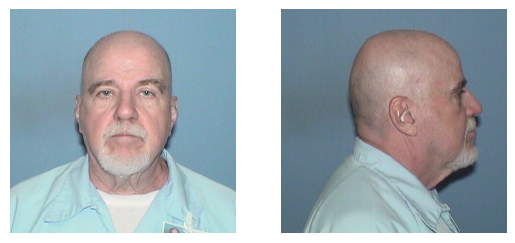

The prisoner number is A00147.
He is 5 ft. 07 in. tall and weighs 185 lbs. with brown hair and blue eyes, identifying racially as White.
This is a sex offender.
Reason for imprisonment: AGGR KIDNAPPING-NO RANSOM, ATTEMPT MURDER/INTENT TO KILL/INJURE, RAPE, BURGLARY
labels contain:        ID   Sex        Height    Weight                    Hair   Eyes   Race  \
0  A00147  Male  5 ft. 07 in.  185 lbs.                   Brown   Blue  White   
1  A00198  Male  6 ft. 02 in.  190 lbs.           Red or Auburn  Brown  White   
2  A00360  Male  5 ft. 09 in.  167 lbs.  Gray or Partially Gray  Green  White   
3  A00367  Male  6 ft. 00 in.  245 lbs.                   Black  Brown  Black   
4  A01054  Male  5 ft. 07 in.  166 lbs.         Salt and Pepper  Brown  Black   

   Sex Offender                                            Offense  \
0          True  AGGR KIDNAPPING-NO RANSOM, ATTEMPT MURDER/INTE...   
1         False  CRIM DMG TO PROP $300-10K, ATTEMPT AGG BATTERY...   
2         False  ARME

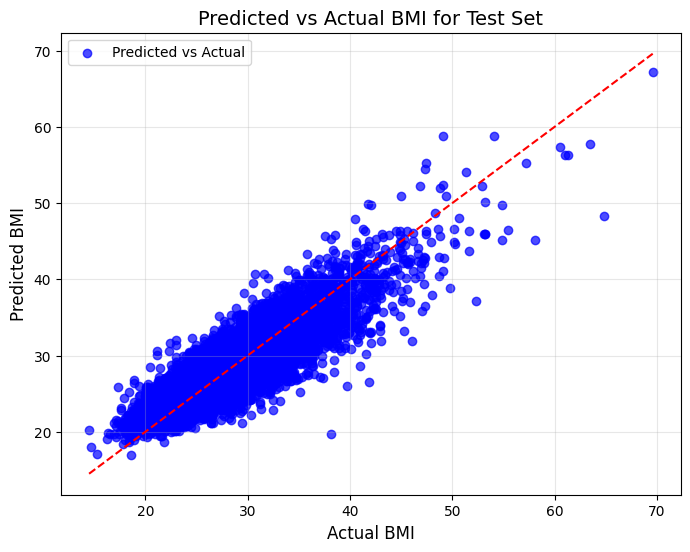

BMI Prediction Metrics:
Mean Absolute Error: 1.9882805722516823
Mean Squared Error: 6.578727104496032
R^2 Score: 0.7506070823502404
 - Pearson Correlation Coefficient: 0.87

Gender Classification Metrics:
Accuracy Score: 0.9438
Enter the path to the front image: /content/front.jpg
Enter the path to the side image: /content/side.jpg
enter the weight in kgs:54


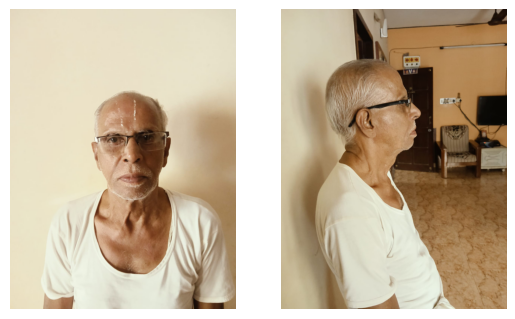

{'Predicted BMI': 19.91, 'Predicted Gender': 'Male', 'predicted bmi class': 'Normal'}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score,mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import pearsonr
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

labels = pd.DataFrame()
labels.drop_duplicates()
labels.dropna()
label = pd.DataFrame()

base_dir = '/root/.cache/kagglehub/datasets/elliotp/idoc-mugshots/versions/2'

def data_loader():
    global labels
    try:

        labels = pd.read_csv(
            os.path.join(base_dir, 'labels_utf8.csv'),
            header=0,
            index_col=None,
            nrows=50000
        )
        print(f"Labels loaded with {len(labels)} records.")
    except Exception as e:
        print(f"Error loading labels: {e}")

def get_sample():
    global label
    print('head:',labels.head())
    if labels.empty:
        print("No data in labels. Make sure to load data first.")
        return None, None, None

    label = labels.iloc[0]


    front_image_path = os.path.join(base_dir, 'front/front', f"{label['ID']}")
    side_image_path = os.path.join(base_dir, 'side/side', f"{label['ID']}")


    front_image = cv2.imread(front_image_path)
    side_image = cv2.imread(side_image_path)

    if front_image is None or side_image is None:
        print(f"Error reading images for ID: {label['ID']}")
        return None, None, label

    return front_image, side_image, label


print("Initializing DataLoader...")
data_loader()
print("DataLoader initialized")


print("Columns in labels DataFrame:", labels.columns)


front_sample, side_sample, sample_label = get_sample()
if front_sample is not None and side_sample is not None:
    print("Sample images loaded successfully.")
    print("Sample label:", sample_label)
else:
    print("Failed to load sample.")
if front_sample is None or side_sample is None:
    print("Error: Could not load sample images.")
else:

    print("Visualizing sample images...")
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(front_sample, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(side_sample, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


    print(f"The prisoner number is {label['ID']}.")
    print(
        f"{'He' if label['Sex'] == 'Male' else 'She'} is {label['Height']} tall and weighs {label['Weight']} "
        f"with {label['Hair'].lower()} hair and {label['Eyes'].lower()} eyes, identifying racially as {label['Race']}."
    )
    if label['Sex Offender'] in ['Yes', 'True', True]:
        print("This is a sex offender.")
    print("Reason for imprisonment:", label['Offense'])



# Function to convert weight from ' .lb.' format to kilograms
def convert_weight_to_kg(weight_str):
    try:
        # Extract the numeric part and convert to kilograms (1 lb = 0.453592 kg)
        weight = float(weight_str.replace('lbs.', '').strip())
        return weight * 0.453592
    except Exception as e:
        print(f"Error converting weight: {weight_str}. {e}")
        return None

# Function to convert height from 'ft. in.' format to meters
def convert_height_to_meters(height_str):
    try:
        # Split height into feet and inches
        parts = height_str.replace('ft.', '').replace('in.', '').strip().split()
        feet = int(parts[0])
        inches = int(parts[1]) if len(parts) > 1 else 0
        # Convert to meters (1 foot = 0.3048 meters, 1 inch = 0.0254 meters)
        height_meters = feet * 0.3048 + inches * 0.0254
        return height_meters
    except Exception as e:
        print(f"Error converting height: {height_str}. {e}")
        return None

# Preprocess the images (resize and normalize)
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found at path: {image_path}")
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img



from skimage.feature import hog
import cv2
import numpy as np
import pandas as pd
'''
def extract_hog_features(image):
    # Compute HOG features for the grayscale image
    features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    return features'''

def extract_features_and_append():
    global labels  # Access the labels DataFrame
    features = []

    for i, row in labels.iterrows():
        # Convert height and weight
        height_meters = convert_height_to_meters(row['Height'])  # Convert height to meters
        weight_kg = convert_weight_to_kg(row['Weight'])          # Convert weight to kilograms

        if height_meters is None or weight_kg is None:
            print(f"Skipping ID {row['ID']} due to invalid height or weight.")
            continue

        front_image_path = os.path.join(base_dir, 'front/front', f"{row['ID']}")  # Ensure proper file extension
        side_image_path = os.path.join(base_dir, 'side/side', f"{row['ID']}")

        # Read images
        front_image = cv2.imread(front_image_path)
        side_image = cv2.imread(side_image_path)

        if front_image is None or side_image is None:
            print(f"Skipping ID {row['ID']} due to missing images.")
            continue

        # Resize images to a fixed size
        front_image_resized = cv2.resize(front_image, (128, 128))
        side_image_resized = cv2.resize(side_image, (128, 128))

        # Convert images to grayscale
        front_gray = cv2.cvtColor(front_image_resized, cv2.COLOR_BGR2GRAY)
        side_gray = cv2.cvtColor(side_image_resized, cv2.COLOR_BGR2GRAY)

        # Extract mean and standard deviation of pixel intensities
        front_mean, front_std = np.mean(front_gray), np.std(front_gray)
        side_mean, side_std = np.mean(side_gray), np.std(side_gray)

        # Extract HOG features
        '''
        hog_front_features = extract_hog_features(front_gray)
        hog_side_features = extract_hog_features(side_gray)'''

        # Combine all features
        image_features = [front_mean, front_std, side_mean, side_std,weight_kg,height_meters] #+ list(hog_front_features) + list(hog_side_features)

        # Append to the list
        features.append(image_features)

    # Convert features list to DataFrame
    feature_df = pd.DataFrame(
        features,
        columns=['Front_Mean', 'Front_Std', 'Side_Mean', 'Side_Std','weight_kg','height_meters']# + [f'HOG_Feature{i}' for i in range(1, len(hog_front_features) + 1)]
    )

    # Add features to the labels DataFrame
    labels = labels.iloc[:len(feature_df)]  # Align rows if some images are skipped
    labels = pd.concat([labels.reset_index(drop=True), feature_df.reset_index(drop=True)], axis=1)
    print('labels contain:',labels.head())

    print("Feature extraction and appending completed.")


# Extract features
extract_features_and_append()

#  BMI is calculated
labels['BMI'] = labels['weight_kg'] / ((labels['height_meters']) ** 2)

# Split data into training and testing sets


# Data preparation
X = labels[['Front_Mean', 'Front_Std', 'Side_Mean', 'Side_Std','weight_kg']]
y_bmi = labels['BMI']
y_gender = labels['Sex'].apply(lambda x: 1 if x == 'Male' else 0)  # Binary encoding

# Train-test split
X_train, X_test, y_bmi_train, y_bmi_test = train_test_split(X, y_bmi, test_size=0.2, random_state=42)
_, _, y_gender_train, y_gender_test = train_test_split(X, y_gender, test_size=0.2, random_state=42)

# Random Forest Regressor for BMI with Cross-Validation
rf_regressor = RandomForestRegressor(random_state=42)
cv_r2_scores = cross_val_score(rf_regressor, X, y_bmi, cv=5, scoring="r2")
print(f"Cross-Validated R^2 Scores for BMI: {cv_r2_scores}")
print(f"Mean R^2 Score: {cv_r2_scores.mean()}")

# Train the model after cross-validation
rf_regressor.fit(X_train, y_bmi_train)
y_bmi_pred = rf_regressor.predict(X_test)
bmi_pearson_corr, _ = pearsonr(y_bmi_test, y_bmi_pred)
print(f"Pearson Correlation (BMI): {bmi_pearson_corr}")

# Random Forest Classifier for Gender with Cross-Validation
rf_classifier = RandomForestClassifier(random_state=42)
cv_accuracy_scores = cross_val_score(rf_classifier, X, y_gender, cv=5, scoring="r2")
print(f"Cross-Validated Accuracy Scores for Gender: {cv_accuracy_scores}")
print(f"Mean Accuracy Score: {cv_accuracy_scores.mean()}")

# Train the model after cross-validation
rf_classifier.fit(X_train, y_gender_train)
y_gender_pred = rf_classifier.predict(X_test)

plt.figure(figsize=(8, 6))

plt.scatter(y_bmi_test, y_bmi_pred, color='blue', alpha=0.7, label='Predicted vs Actual')

plt.title('Predicted vs Actual BMI for Test Set', fontsize=14)
plt.xlabel('Actual BMI', fontsize=12)
plt.ylabel('Predicted BMI', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
min_val = min(min(y_bmi_test), min(y_bmi_pred))
max_val = max(max(y_bmi_test), max(y_bmi_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Line of Truth')

plt.show()

# Metrics for BMI prediction
print("BMI Prediction Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_bmi_test, y_bmi_pred))
print("Mean Squared Error:", mean_squared_error(y_bmi_test, y_bmi_pred))
print("R^2 Score:", r2_score(y_bmi_test, y_bmi_pred))
print(f" - Pearson Correlation Coefficient: {bmi_pearson_corr:.2f}")

# Metrics for Gender classification
print("\nGender Classification Metrics:")
print("Accuracy Score:", accuracy_score(y_gender_test, y_gender_pred))


# Classify the BMI values
def classify_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obese"


import cv2
import numpy as np

def predict_bmi_gender_with_input(rf_regressor, rf_classifier):

    try:
        # Get image paths from user
        front_image_path = input("Enter the path to the front image: ").strip()
        side_image_path = input("Enter the path to the side image: ").strip()
        weight=  int(input("enter the weight in kgs:"))


        # Load the images
        front_image = cv2.imread(front_image_path)
        side_image = cv2.imread(side_image_path)

        # Check if images are loaded correctly
        if front_image is None or side_image is None:
            raise ValueError("One or both images could not be loaded. Please check the paths.")

        plt.figure(1)
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(front_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(side_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Preprocess images: resize to a fixed size and convert to grayscale
        front_image_resized = cv2.resize(front_image, (128, 128))
        side_image_resized = cv2.resize(side_image, (128, 128))
        front_gray = cv2.cvtColor(front_image_resized, cv2.COLOR_BGR2GRAY)
        side_gray = cv2.cvtColor(side_image_resized, cv2.COLOR_BGR2GRAY)

        # Extract features: mean and standard deviation of pixel intensities
        front_mean, front_std = np.mean(front_gray), np.std(front_gray)
        side_mean, side_std = np.mean(side_gray), np.std(side_gray)

        # Combine features into a single array
        features = np.array([front_mean, front_std, side_mean, side_std,weight]).reshape(1, -1)

        # Predict BMI and gender
        predicted_bmi = rf_regressor.predict(features)[0]
        bmiclass=classify_bmi(predicted_bmi)
        predicted_gender = rf_classifier.predict(features)[0]
        predicted_gender_label = "Male" if predicted_gender == 1 else "Female"


        # Return the predictions
        result = {
            "Predicted BMI": round(predicted_bmi, 2),
            "Predicted Gender": predicted_gender_label,
            "predicted bmi class":bmiclass
        }

        return result

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Example usage
# Assuming `rf_regressor` and `rf_classifier` are pre-trained models
predictions = predict_bmi_gender_with_input(rf_regressor, rf_classifier)

print(predictions)


Unique Keywords from Offenses (split by comma):
000
000 grams
15
18+ del sub
2nd degree murder
2nd degree murder/unreason
2nd/misuse of credit card
agg aslt/peace officer/weapon
agg assault/correctional off
agg assault/deadly weapon
agg battery of a child
agg battery w/firearm/person
agg battery/correctional emp
agg battery/govt employee
agg battery/great bodily harm
agg battery/harm merchant
agg battery/indiv over 60 yrs
agg battery/peace off/fireman
agg battery/peace officer
agg battery/public place
agg battery/use deadly weapon
agg battery/weapon/no firearm
agg btry/fireman/paramedic etc
agg btry/great bod harm/pc off
agg btry/harm/peace officer
agg btry/harm/police/doc/dhs
agg btry/officer/empl/govt
agg btry/pregnant/handicapped
agg crim sex ab/vic
agg crim sex ab/vic 13-16
agg crim sex abuse
agg crim sex abuse/family
agg crim sex abuse/vic
agg crim sex abuse/victim
agg crim sex abuse/weapon
agg crim sex aslt/bodily harm
agg crim sex aslt/threat life
agg crim sex aslt/victim
agg cr

<ipython-input-5-9ddf796a48b6>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_idx].set_xticklabels(chunk_data.index, rotation=90)
<ipython-input-5-9ddf796a48b6>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_idx].set_xticklabels(chunk_data.index, rotation=90)
<ipython-input-5-9ddf796a48b6>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_idx].set_xticklabels(chunk_data.index, rotation=90)
<ipython-input-5-9ddf796a48b6>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[ax_idx].set_xticklabels(chunk_data.index, rotation=90)
<ipython-input-5-9ddf796a48b6>:54: UserWarning: set_ticklabels() should only be used with a fixed nu

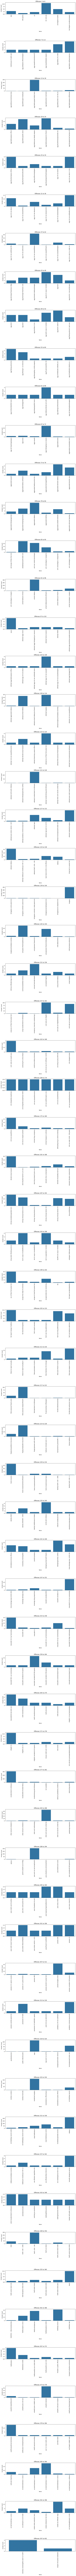

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


unique_offenses = labels['Offense'].unique()


def extract_unique_keywords_by_comma(offenses):
    all_keywords = set()

    for offense in offenses:

        split_keywords = offense.split(',')

        for keyword in split_keywords:
            cleaned_keyword = keyword.strip().lower()
            if cleaned_keyword:
                all_keywords.add(cleaned_keyword)

    return sorted(all_keywords)

unique_keywords = extract_unique_keywords_by_comma(unique_offenses)

print("Unique Keywords from Offenses (split by comma):")
for keyword in unique_keywords:
    print(keyword)

def mark_offenses(row, unique_keywords):
    offense_list = row.split(',')  # Split the offense string
    offense_list = [offense.strip().lower() for offense in offense_list]  # Clean the offenses
    offense_flags = {offense: 1 if offense in offense_list else 0 for offense in unique_keywords}
    return offense_flags


offense_columns = pd.DataFrame(labels['Offense'].apply(lambda x: mark_offenses(x, unique_keywords)).to_list())

df_offenses = pd.concat([labels['ID'], offense_columns], axis=1)

num_plots = 6
num_rows = (len(unique_keywords) // num_plots) + 1

fig, axes = plt.subplots(num_rows, 1, figsize=(10, num_rows * 5))

axes = axes.flatten()

for i in range(0, len(unique_keywords), num_plots):
    chunk = unique_keywords[i:i + num_plots]
    chunk_data = df_offenses[chunk].sum(axis=0)
    ax_idx = i // num_plots

    sns.barplot(x=chunk_data.index, y=chunk_data.values, ax=axes[ax_idx])
    axes[ax_idx].set_title(f'Offenses {i + 1} to {i + num_plots}')
    axes[ax_idx].set_xticklabels(chunk_data.index, rotation=90)
    axes[ax_idx].set_ylabel('Inmate Count')

plt.tight_layout()
plt.show()

